Test du projet de class trajets indirect

In [1]:
%load_ext autoreload
%autoreload 2
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import traitement_od as t
import pandas as pd
import numpy as np
import altair as alt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
import os
from sklearn.cluster import DBSCAN

IMPORT DONNEES GLOBALES

In [2]:
%time df_3semaines=t.ouvrir_fichier_lapi('2019-01-28 00:00:00','2019-02-17 23:59:59').set_index('created').sort_index()

Wall time: 1min 10s


IMPORT DES DONNEES SUR UNE JOURNEE

In [350]:
df_journee=t.ouvrir_fichier_lapi('2019-01-28','2019-01-30')

In [352]:
#redresser la valeur de l
df_journee.loc[df_journee['camera_id']==15,'l']=1

LISTE DES TRAJETS

In [3]:
liste_trajet_locale=(pd.DataFrame([{'origine':'A63','destination':'A10','cam_o':15, 'cam_d':11, 'trajets':[
                                                        {'cameras':[15,19,4,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,1,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,4,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,1,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,4,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,1,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,4,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,1,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,11],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A63','cam_o':12, 'cam_d':13,'trajets':[{'cameras':[12,6,2,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,2,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,2,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,2,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,13],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A63','destination':'N10','cam_o':15, 'cam_d':5,'trajets':[{'cameras':[15,19,4,5],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,1,5],'type_trajet':'indirect'},
                                                        {'cameras':[15,4,5],'type_trajet':'indirect'},
                                                        {'cameras':[15,1,5],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,5],'type_trajet':'indirect'}, 
                                                        {'cameras':[15,5],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'N10','destination':'A63','cam_o':6, 'cam_d':13,'trajets':[{'cameras':[6,2,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,2,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,13],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A62','destination':'A10','cam_o':10, 'cam_d':11,'trajets':[{'cameras':[10,4,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[10,4,11],'type_trajet':'indirect'},
                                                        {'cameras':[10,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[10,11],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A62','cam_o':12, 'cam_d':9,'trajets':[{'cameras':[12,6,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,9],'type_trajet':'indirect'},
                                                        {'cameras':[12,9],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A62','destination':'N10','cam_o':10, 'cam_d':5,'trajets':[{'cameras':[10,4,5],'type_trajet':'indirect'},
                                                        {'cameras':[10,5],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'N10','destination':'A62','cam_o':6, 'cam_d':9,'trajets':[{'cameras':[6,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[6,9],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A63','destination':'A62','cam_o':15, 'cam_d':9,'trajets':[{'cameras':[15,19,9],'type_trajet':'indirect'},
                                                        {'cameras':[15,9],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A62','destination':'A63','cam_o':10, 'cam_d':13,'trajets':[{'cameras':[10,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[10,13],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A89','destination':'A63','cam_o':8 ,'cam_d':13,'trajets':[{'cameras':[8,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[8,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[8,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[8,13],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A63','destination':'A89','cam_o':15, 'cam_d':7,'trajets':[{'cameras':[15,19,4,7],'type_trajet':'indirect'},
                                                        {'cameras':[15,4,7],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,7],'type_trajet':'indirect'},
                                                        {'cameras':[15,7],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A89','destination':'A62','cam_o':8, 'cam_d':9,'trajets':[{'cameras':[8,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[8,9],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A62','destination':'A89','cam_o':10, 'cam_d':7,'trajets':[{'cameras':[10,4,7],'type_trajet':'indirect'},
                                                        {'cameras':[10,7],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A89','destination':'A10','cam_o':8, 'cam_d':11,'trajets':[{'cameras':[8,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[8,11],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A89','cam_o':12, 'cam_d':7,'trajets':[{'cameras':[12,6,7],'type_trajet':'indirect'},
                                                        {'cameras':[12,7],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A89','destination':'N10','cam_o':8, 'cam_d':5,'trajets':[{'cameras':[8,5],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'N10','destination':'A89','cam_o':6, 'cam_d':7,'trajets':[{'cameras':[6,7],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A660','cam_o':12, 'cam_d':18,'trajets':[{'cameras':[12,6,2,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,6,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,2,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,6,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,18],'type_trajet':'direct'},
                                                        ]},
                            {'origine':'A660','destination':'A10','cam_o':19, 'cam_d':18,'trajets':[{'cameras':[19,4,5,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,1,5,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,1,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,4,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,5,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,11],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A660','destination':'A62','cam_o':19, 'cam_d':9,'trajets':[{'cameras':[19,9],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'A62','destination':'A660','cam_o':10, 'cam_d':18,'trajets':[{'cameras':[10,18],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'A660','destination':'A89','cam_o':19, 'cam_d':7,'trajets':[{'cameras':[19,4,7],'type_trajet':'indirect'},
                                                         {'cameras':[19,7],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'A89','destination':'A660','cam_o':8, 'cam_d':18,'trajets':[{'cameras':[8,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[8,18],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'N10','destination':'A660','cam_o':6, 'cam_d':18,'trajets':[{'cameras':[6,2,18],'type_trajet':'indirect'},
                                                         {'cameras':[6,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[6,18],'type_trajet':'direct'},
                                                        ]},
                            {'origine':'A660','destination':'N10','cam_o':19, 'cam_d':5,'trajets':[{'cameras':[19,1,5],'type_trajet':'indirect'},
                                                         {'cameras':[19,4,5],'type_trajet':'indirect'},
                                                         {'cameras':[19,5],'type_trajet':'direct'},
                                                        ]}
                           ]))[['origine', 'destination', 'cam_o', 'cam_d','trajets']]

In [730]:
%time test=t.trajet(df_journee, '2019-01-29 08:00:00', 60, 16, [6,13], type='Global')

Wall time: 6.33 s


CALCUL DES O-D SUR UNE JOURNEE, AVEC RENVOI DES DF O-D OU PASSAGES DANS UN DICO PAR O-D OU UNE DF GLOBALE

In [353]:
dico_trajet_od, dico_passag_od, dico_od,  dico_passag=t.transit_1_jour(df_journee,'2019-01-28 08:00:00', liste_trajet_locale)

date : 2019-01-28 08:00:00 debut_traitement : 2019-04-05 15:32:42.058239
date : 2019-01-28 09:00:00 debut_traitement : 2019-04-05 15:35:25.209336


IMPORTANT : VERIF DES DOUBLONS ENTRE LES TRAJETS

In [10]:
A660N10=dico_passag_od['A660-N10'].set_index(['created','immat'])
A63N10=dico_passag_od['A63-N10'].set_index(['created','immat'])
A63N10.loc[A63N10.index.isin(A660N10.index)].reset_index().set_index('created')

,immat,camera_id,fiability,l,state
created,,,,,


CREER LE TABLEAU DE MATRICE O-D

In [9]:
#MATRICE O-D !!II!
pd.pivot_table(dico_od,values='l', index='origine', columns='destination',aggfunc='count', margins=True )

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NaN,5603.0,1689.0,2121.0,223.0,NaN,9636
A62,1024.0,NaN,226.0,560.0,346.0,1589.0,3745
A63,1314.0,126.0,NaN,NaN,653.0,13322.0,15415
A660,NaN,827.0,NaN,NaN,1540.0,7920.0,10287
A89,292.0,853.0,1156.0,1525.0,NaN,896.0,4722
N10,NaN,3285.0,15664.0,5372.0,595.0,NaN,24916
All,2630.0,10694.0,18735.0,9578.0,3357.0,23727.0,68721


POURCENTAGE PL PAR PLAGE HORAIRE ET CAMERA

In [432]:
#isoler pl source
groupe_tv_type_simple=df_journee.groupby('immat')['l'].apply(lambda x:test_unicite_type(list(x),mode='1/2')).reset_index().drop_duplicates('immat')
df_pl=df_journee.join(groupe_tv_type_simple.loc[groupe_tv_type_simple['l']==1].set_index('immat'),on='immat',how='inner',rsuffix='_right')
df_pl.set_index('created',inplace=True)

#obtenir les nb de pl par heure et par camera sur la source
df_synthese_pl_tot=df_pl.groupby('camera_id').resample('H').count()['immat'].rename(column={'immat':'nb_pl_tot'})
df_synthese_pl_transit=dico_passag.set_index('created').groupby('camera_id').resample('H').count()['immat'].rename(column={'immat':'nb_pl_transit'})
df_pct_pl_transit=pd.concat([df_synthese_pl_tot,df_synthese_pl_transit], axis=1, join='inner')
df_pct_pl_transit.columns=[['nb_pl_tot','nb_pl_transit']]
df_pct_pl_transit['pct_pl_transit']=df_pct_pl_transit.apply(lambda x : float(x['nb_pl_transit'])*100 / x['nb_pl_tot'] ,axis=1)
df_pct_pl_transit

TESTS DONNEES COMPLETES

In [7]:
dico_trajet_od, dico_passag_od, dico_od,  dico_passag=t.transit_temps_complet_v2('2019-01-28 00:00:00',21,liste_trajet_locale,df_3semaines)

date : 2019-01-28 00:00:00 debut_traitement : 2019-04-05 17:14:07.432442
date : 2019-01-28 01:00:00 debut_traitement : 2019-04-05 17:14:07.963569
date : 2019-01-28 02:00:00 debut_traitement : 2019-04-05 17:14:08.713393
date : 2019-01-28 03:00:00 debut_traitement : 2019-04-05 17:14:09.307003
date : 2019-01-28 04:00:00 debut_traitement : 2019-04-05 17:14:09.838130
date : 2019-01-28 05:00:00 debut_traitement : 2019-04-05 17:14:10.213042
date : 2019-01-28 06:00:00 debut_traitement : 2019-04-05 17:14:10.603577
date : 2019-01-28 07:00:00 debut_traitement : 2019-04-05 17:14:10.978487
date : 2019-01-28 08:00:00 debut_traitement : 2019-04-05 17:14:11.353398
date : 2019-01-28 09:00:00 debut_traitement : 2019-04-05 17:14:11.743935
date : 2019-01-28 10:00:00 debut_traitement : 2019-04-05 17:14:12.118848
date : 2019-01-28 11:00:00 debut_traitement : 2019-04-05 17:14:12.509377
date : 2019-01-28 12:00:00 debut_traitement : 2019-04-05 17:14:12.899915
date : 2019-01-28 13:00:00 debut_traitement : 2019-

In [37]:
#verifs
dico_passag_od['A660-N10'].set_index('created').loc['2019-01-31 08:00:00':].sort_index().head(5) #visualiser les passages

,camera_id,immat,fiability,l,state
created,,,,,
2019-01-31 08:00:30,19,9dd7529a19c83bed931c0d4b40840b7a36328e20,99,1,ES
2019-01-31 08:01:56,19,574c4311fa597da55a2aac80e1097129dd7419e1,99,-1,FR
2019-01-31 08:02:15,19,c57c4941aadcb97905b3ef0e410578f22f516efa,99,-1,ES
2019-01-31 08:02:38,19,8ddc4c2f1189ae0a4224f688200b211c3fd0f675,99,1,ES
2019-01-31 08:02:49,19,d735cccf1331cd23ba652c145358f46405bbc306,99,0,ES


In [40]:
df_3semaines.loc[df_3semaines['immat']=='8ddc4c2f1189ae0a4224f688200b211c3fd0f675']#retrouver cette immatriculatiob dans les données completes

,camera_id,immat,fiability,l,state
created,,,,,
2019-01-30 21:51:20,15,8ddc4c2f1189ae0a4224f688200b211c3fd0f675,99,-1,ES
2019-01-31 08:02:38,19,8ddc4c2f1189ae0a4224f688200b211c3fd0f675,99,1,ES
2019-01-31 08:48:31,5,8ddc4c2f1189ae0a4224f688200b211c3fd0f675,99,1,ES
2019-02-06 08:23:12,8,8ddc4c2f1189ae0a4224f688200b211c3fd0f675,99,1,ES
2019-02-06 08:48:45,3,8ddc4c2f1189ae0a4224f688200b211c3fd0f675,99,1,ES
2019-02-06 09:18:21,18,8ddc4c2f1189ae0a4224f688200b211c3fd0f675,99,0,ES
2019-02-06 11:37:39,13,8ddc4c2f1189ae0a4224f688200b211c3fd0f675,99,-1,ES


In [43]:
#verif sur un trajet a unhoraire donnee
%time test=t.trajet(df_3semaines.loc['2019-01-29 21:00:00':'2019-01-30 15:00:00'], '2019-01-29 21:00:00', 60, 16, [15,5], type='Global')

PasDePlError: pas de PL sur la période et les cameras visées

In [117]:
%time test=t.trajet(df_3semaines.loc['2019-01-29 21:00:00':'2019-01-30 15:00:00'], '2019-01-29 21:00:00', 60, 16, [15,19])

Wall time: 109 ms


In [118]:
test.temps_parcours_max

Timedelta('0 days 00:37:54')

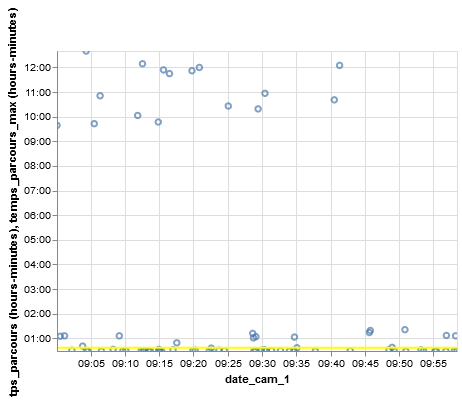

In [119]:
test.graph()